<a href="https://colab.research.google.com/github/silviutroscot/Signal-Processing-Playground/blob/master/Haar_Bases_for_Image_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%pylab inline
from google.colab import drive
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import Image
import math
from __future__ import print_function

#drive.mount('/content/drive')

# ensure all images will be grayscale
gray()

Populating the interactive namespace from numpy and matplotlib


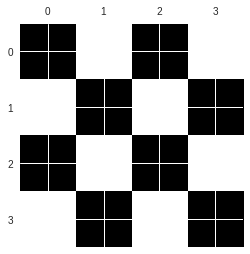

In [9]:
# create a checkerboard pattern
k_size = 4
img = np.zeros((k_size, k_size))
for n in range(0, k_size):
    for m in range(0, k_size):
        if ((n + m) % 2 != 0):
            img[n, m] = 255

# now display the matrix as an image
plt.matshow(img)

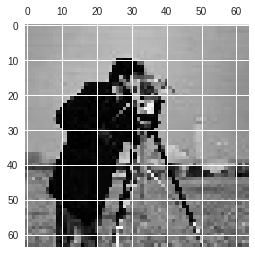

In [11]:
# upload image from drive

with open ('drive/My Drive/collabFiles/cameraman.jpg', 'rb') as image:
  img = np.array(plt.imread(image), dtype=int)

plt.matshow(img)
plt.show()

# The canonical basis
A canonical basis for a space $R^{M*N}$ is a set of matrices is a set of matrices where only one element is 1 and the others are 0.

In [0]:
def construct_canonical_basis(M, N):
  canonical_basis = []
  for i in range (0, M*N):
    basis_element = np.zeros((M, N))
    basis_element[(i % M), int(i/M)] = 1
    canonical_basis.append(basis_element)
    
  canonical_basis = np.asarray(canonical_basis)
  return canonical_basis

print (construct_canonical_basis(3,4))

## To transmit the image we would only need to transmit the coefficients of the decomposition of the image over a 64x64 basis.
This involves sending 64*64=4096 coefficients over the network. 

Now, if something happens and we were able to send only half of the coefficients over the network, the result is very bad.

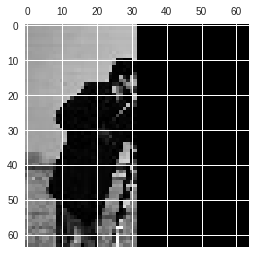

In [72]:
flatened_img = np.ravel(img, 'F')
flatened_img[int(len(flatened_img)/2):] = 0

# rebuild matrix
reshaped_img = np.reshape(flatened_img, (64, 64), 'F')
plt.matshow(reshaped_img)

## We should find a basis which is more robust to loosing some coefficients.
One example of this kind of basis is **Haar basis**.

The Haar wavelet is defined as $ 
h(x)= \left\{
\begin{array}{ll}
      1 & 0 < x  \leq \frac{1}{2} \\
      -1 & 1/2< x\leq 1\\
      0 & otherwise
\end{array} 
\right. 
$
### The maths goes further and more details can be found [here](https://users.math.yale.edu/pub/wavelets/software/xwpl/html/manual/node28.html) and [here](http://aix1.uottawa.ca/~jkhoury/haar.htm). The Haar basis works in a *hierarchical* way: the first basis vectors encode the broader information and the higher coefficients encode the detail.

In [0]:
def haar_1D(n, SIZE):
  # check power of two
    if math.floor(math.log(SIZE) / math.log(2)) != math.log(SIZE) / math.log(2):
        print("Haar defined only for lengths that are a power of two")
        return None
    if n >= SIZE or n < 0:
        print("invalid Haar index")
        return None
    
    # zero basis vector
    if n == 0:
        return np.ones(SIZE)
    
    # express n > 1 as 2^p + q with p as large as possible;
    # then k = SIZE/2^p is the length of the support
    # and s = qk is the shift
    p = math.floor(math.log(n) / math.log(2))
    pp = int(pow(2, p))
    k = SIZE / pp
    s = (n - pp) * k
    
    h = np.zeros(SIZE)
    h[int(s):int(s+k/2)] = 1
    h[int(s+k/2):int(s+k)] = -1
    # these are not normalized
    return h


def haar2D(n, SIZE=8):
    # get horizontal and vertical indices
    hr = haar_1D(n % SIZE, SIZE)
    hv = haar_1D(int(n / SIZE), SIZE)
    # 2D Haar basis matrix is separable, so we can
    #  just take the column-row product
    H = np.outer(hr, hv)
    H = H / math.sqrt(np.sum(H * H))
    return H
    

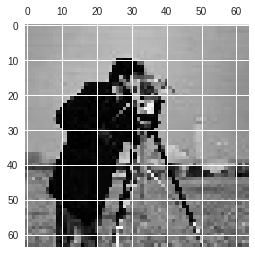

In [24]:
# project the image onto the Haar basis, obtaining a vector of 4096 coefficients
# this is simply the analysis formula for the vector space with an orthogonal basis
tx_img = np.zeros(64*64)
for k in range(0, (64*64)):
    tx_img[k] = np.sum(img * haar2D(k, 64))

# now rebuild the image with the synthesis formula; since the basis is orthonormal
#  we just need to scale the basis matrices by the projection coefficients
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += tx_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

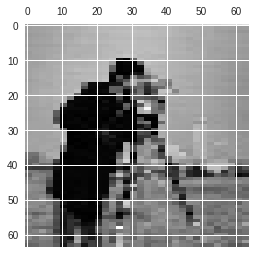

In [25]:
# simulate the lose of half of the data
lossy_img = np.copy(tx_img);
lossy_img[int(len(tx_img)/2):] = 0

# rebuild matrix
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += lossy_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

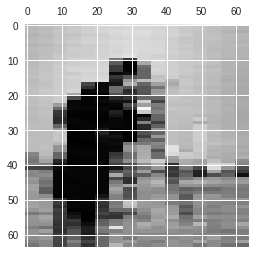

In [28]:
# simulate loosing 3/4 of data
lossy_img = np.copy(tx_img);
lossy_img[int(len(tx_img)/4):] = 0

# rebuild matrix
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += lossy_img[k] * haar2D(k, 64)

plt.matshow(rx_img);